In [69]:
# Data loading and merging
import os
from glob import glob
import pandas as pd

# Define the path to the datasets
data_path = os.path.join("..","data","raw")

# Get list of Excel files natching *_cars.xlsx
file_paths = glob(os.path.join(data_path, "*_cars.xlsx"))

# Load and merge all Excel files
all_dataframes = []
for file_path in file_paths:
    city_name = os.path.basename(file_path).split('_')[0].capitalize() # Extract city from the filename
    df = pd.read_excel(file_path)
    df['City'] = city_name
    all_dataframes.append(df)

# Concatenate all dataframes
merged_df = pd.concat(all_dataframes, ignore_index=True)

print(f" Merged Data Dataset: \n{merged_df.columns.tolist()}")
print(f" Merged Data Dataset: \n{merged_df.head()}")
print(f" Merged Data Dataset: \n{merged_df.shape}")

# Define the output path
output_path = os.path.join("..","outputs", "merged_car_data.csv")
merged_df.to_csv(output_path, index=False)


 Merged Data Dataset: 
['new_car_detail', 'new_car_overview', 'new_car_feature', 'new_car_specs', 'car_links', 'City']
 Merged Data Dataset: 
                                      new_car_detail  \
0  {'it': 0, 'ft': 'Petrol', 'bt': 'Hatchback', '...   
1  {'it': 0, 'ft': 'Petrol', 'bt': 'SUV', 'km': '...   
2  {'it': 0, 'ft': 'Petrol', 'bt': 'Hatchback', '...   
3  {'it': 0, 'ft': 'Petrol', 'bt': 'Sedan', 'km':...   
4  {'it': 0, 'ft': 'Diesel', 'bt': 'SUV', 'km': '...   

                                    new_car_overview  \
0  {'heading': 'Car overview', 'top': [{'key': 'R...   
1  {'heading': 'Car overview', 'top': [{'key': 'R...   
2  {'heading': 'Car overview', 'top': [{'key': 'R...   
3  {'heading': 'Car overview', 'top': [{'key': 'R...   
4  {'heading': 'Car overview', 'top': [{'key': 'R...   

                                     new_car_feature  \
0  {'heading': 'Features', 'top': [{'value': 'Pow...   
1  {'heading': 'Features', 'top': [{'value': 'Pow...   
2  {'heading': '

| Column             | Description                                                               | EDA Usefulness | Action Needed                            |
| ------------------ | ------------------------------------------------------------------------- | -------------- | ---------------------------------------- |
| new_car_detail   | JSON-like string with key info: price, km, fuel, transmission, model year | ✅ High         | ✅ Flatten (already done earlier)         |
| new_car_overview | JSON-like structure with top-level info like registration, insurance      | ⏳ Medium       | Can extract later if needed              |
| new_car_feature  | Feature list (comfort, safety, etc.)                                      | ⏳ Low–Medium   | Optional; not structured for numeric EDA |
| new_car_specs    | Contains mileage, engine size, power, etc. (nested dicts)                 | ✅ High         | 🚧 Needs flattening                      |
| car_links        | URL of listing                                                            | ❌ None         | 🔻 Drop or ignore                        |
| City             | City name                                                                 | ✅ High         | ➕ Use in grouping, distribution          |


| Feature                      | From Column        | Purpose                         |
| ---------------------------- | ------------------ | ------------------------------- |
| `price`                      | new\_car\_detail   | Target variable                 |
| `modelYear`                  | new\_car\_detail   | Car age                         |
| `km`                         | new\_car\_detail   | Mileage usage                   |
| `ft` (fuel)                  | new\_car\_detail   | Categorical grouping            |
| `transmission`               | new\_car\_detail   | Categorical grouping            |
| `ownerNo`                    | new\_car\_detail   | Ownership status                |
| `City`                       | (already separate) | Regional analysis               |
| `engine`, `power`, `mileage` | new\_car\_specs    | Feature importance, correlation |


In [70]:
# Define the merged_data_path
merged_data_path = os.path.join("..", "outputs")
merged_data = os.path.join(merged_data_path, "merged_car_data.csv")
flattened_df = pd.read_csv(merged_data)


# Parse 'new_car_detail' column to extract price, km etc..
def safe_eval(val):
    if isinstance(val, str):
        try:
            return eval(val)
        except:
            return
    elif isinstance(val, dict):
        return val
    else:
        return

detail_dicts = flattened_df['new_car_detail'].apply(safe_eval)
detail_df = pd.DataFrame(detail_dicts.tolist(), columns= ['price', 'km'])

# clean 'price': remove currency symbols, 'Lakh', and convert to float
def clean_price(value):
    if isinstance(value, str):
        value = value.replace("₹", "").replace(",", "").replace("Lakh", "").strip()
        try:
            return float(value) * 100000 # Convert Lakh to actual amount
        except:
            return None
    return None

# clean 'km': remove 'kms' or commas and convert to int
def _clean_km(value):
    if isinstance(value, str):
        value = value.replace(",", "").replace("kms", "").replace("km", "").strip()
        try:
            return int(value)
        except:
            return None
    return None

# Apply cleaning functions
detail_df['price_cleaned'] = detail_df['price'].apply(clean_price)
detail_df['km_cleaned'] = detail_df['km'].apply(_clean_km)

# Print the DataFrame after cleaning functions are applied
print(detail_df[['price', 'price_cleaned', 'km', 'km_cleaned']].head(10).to_string(index=False))


      price  price_cleaned       km  km_cleaned
   ₹ 4 Lakh       400000.0 1,20,000      120000
₹ 8.11 Lakh       811000.0   32,706       32706
₹ 5.85 Lakh       585000.0   11,949       11949
₹ 4.62 Lakh       462000.0   17,794       17794
₹ 7.90 Lakh       790000.0   60,000       60000
  ₹ 19 Lakh      1900000.0   20,000       20000
₹ 3.45 Lakh       345000.0   37,772       37772
  ₹ 12 Lakh      1200000.0   30,000       30000
₹ 9.60 Lakh       960000.0   37,000       37000
₹ 5.85 Lakh       585000.0   11,949       11949


In [29]:
full_detail_df = pd.DataFrame(detail_dicts.tolist())
# Add city and car_links
full_detail_df['City'] = merged_df['City']
full_detail_df['car_links'] = merged_df['car_links']

# Check column info and missing values
column_info = full_detail_df.describe(include='all').transpose()
missing_values = full_detail_df.isnull().sum()
print(missing_values)

it                     0
ft                     0
bt                     0
km                     0
transmission           0
ownerNo                0
owner                  0
oem                    0
model                  0
modelYear              0
centralVariantId       0
variantName            0
price                  0
priceActual            0
priceSaving            0
priceFixedText      8369
trendingText           0
City                   0
car_links              0
dtype: int64


In [30]:
print(full_detail_df)

      it      ft         bt        km transmission  ownerNo      owner  \
0      0  Petrol  Hatchback  1,20,000       Manual        3  3rd Owner   
1      0  Petrol        SUV    32,706       Manual        2  2nd Owner   
2      0  Petrol  Hatchback    11,949       Manual        1  1st Owner   
3      0  Petrol      Sedan    17,794       Manual        1  1st Owner   
4      0  Diesel        SUV    60,000       Manual        1  1st Owner   
...   ..     ...        ...       ...          ...      ...        ...   
8364   0  Petrol  Hatchback    10,000       Manual        1  1st Owner   
8365   0  Petrol  Hatchback  1,20,000       Manual        1  1st Owner   
8366   0  Petrol      Sedan    50,000    Automatic        3  3rd Owner   
8367   0  Petrol  Hatchback    40,000       Manual        1  1st Owner   
8368   0  Diesel        SUV  1,20,000       Manual        2  2nd Owner   

                oem                  model  modelYear  centralVariantId  \
0            Maruti         Maruti C

In [32]:
# Select and rename relevant categorical columns for clarity
categorical_df = full_detail_df[['transmission', 'ft', 'owner']].rename(columns={
    'ft': 'fuel_type',
    'owner': 'ownership_status'
})

# Check unique values before encoding
transmission_unique = categorical_df['transmission'].unique().tolist()
fuel_type_unique = categorical_df['fuel_type'].unique().tolist()
ownership_unique = categorical_df['ownership_status'].unique().tolist()

# Apply label encoding for visualization
categorical_encoded = categorical_df.apply(lambda col: pd.factorize(col)[0])

# Combine with original for comparison
encoded_summary = pd.concat([categorical_df, categorical_encoded.add_suffix("_encoded")],axis=1)

print(encoded_summary)

     transmission fuel_type ownership_status  transmission_encoded  \
0          Manual    Petrol        3rd Owner                     0   
1          Manual    Petrol        2nd Owner                     0   
2          Manual    Petrol        1st Owner                     0   
3          Manual    Petrol        1st Owner                     0   
4          Manual    Diesel        1st Owner                     0   
...           ...       ...              ...                   ...   
8364       Manual    Petrol        1st Owner                     0   
8365       Manual    Petrol        1st Owner                     0   
8366    Automatic    Petrol        3rd Owner                     1   
8367       Manual    Petrol        1st Owner                     0   
8368       Manual    Diesel        2nd Owner                     0   

      fuel_type_encoded  ownership_status_encoded  
0                     0                         0  
1                     0                         1  
2  

### 📉**Descriptive Statistics**

In [37]:
# Compute car age assuming current year is 2025
# Apply cleaning and create derived fields
full_detail_df['price_cleaned'] = full_detail_df['price'].apply(clean_price)
full_detail_df['km_cleaned'] = full_detail_df['km'].apply(_clean_km)
full_detail_df['car_age'] = 2025 - full_detail_df['modelYear']

# Compute descriptive statistics on numeric columns
numeric_cols = full_detail_df[['price_cleaned', 'km_cleaned', 'car_age', 'ownerNo']]
numeric_stats = numeric_cols.describe().transpose()

print(f"📉 Descriptive Statistics of Numerical Columns:")
print(numeric_stats.to_string())

📉 Descriptive Statistics of Numerical Columns:
                count          mean           std       min       25%       50%       75%           max
price_cleaned  8349.0  8.911557e+07  7.924329e+08  100000.0  403000.0  620000.0  978000.0  9.970300e+09
km_cleaned     8369.0  5.897430e+04  7.406100e+04       0.0   30000.0   53692.0   80000.0  5.500000e+06
car_age        8369.0  8.496714e+00  3.921465e+00       2.0       6.0       8.0      11.0  4.000000e+01
ownerNo        8369.0  1.360139e+00  6.419585e-01       0.0       1.0       1.0       2.0  5.000000e+00


In [ ]:
from IPython.display import Markdown, display

# Use the already loaded merged_df from previous cells

# Define functions again
def safe_eval(val):
    if isinstance(val, str):
        try:
            return eval(val)
        except:
            return {}
    elif isinstance(val, dict):
        return val
    else:
        return {}

def clean_price(value):
    if isinstance(value, str):
        value = value.replace("₹", "").replace(",", "").replace("Lakh", "").strip()
        try:
            return float(value) * 100000
        except:
            return None
    return None

def clean_km(value):
    if isinstance(value, str):
        value = value.replace(",", "").replace("kms", "").replace("km", "").strip()
        try:
            return int(value)
        except:
            return None
    return None

# Flatten and clean detail data
full_detail_df = pd.DataFrame(merged_df['new_car_detail'].apply(safe_eval).tolist())
full_detail_df['price_cleaned'] = full_detail_df['price'].apply(clean_price)
full_detail_df['km_cleaned'] = full_detail_df['km'].apply(clean_km)
full_detail_df['car_age'] = 2025 - full_detail_df['modelYear']

# Compute numeric stats
numeric_cols = full_detail_df[['price_cleaned', 'km_cleaned', 'car_age', 'ownerNo']]
numeric_stats = numeric_cols.describe().transpose()

# Function to format numbers
def format_large_number(val):
    if val >= 1e7:
        return f"₹{val/1e7:.1f} Cr"
    elif val >= 1e5:
        return f"₹{val/1e5:.2f} L"
    else:
        return f"{val:,.0f}"

# Build markdown table
markdown_rows = []
for idx, row in numeric_stats.iterrows():
    values = [idx]
    for col in ['mean', 'std', 'min', '25%', '50%', '75%', 'max']:
        values.append(format_large_number(row[col]))
    markdown_rows.append("| " + " | ".join(values) + " |")

headers = "| Feature | Mean | Std Dev | Min | 25% | Median | 75% | Max |"
separator = "|---" * 8 + "|"

markdown_table = "### 📊 **Descriptive Statistics of Numerical Features**\n\n"
markdown_table += headers + "\n" + separator + "\n" + "\n".join(markdown_rows)

# Display as markdown
display(Markdown(markdown_table))


### 📊 **Descriptive Statistics of Numerical Features**

| Feature | Mean | Std Dev | Min | 25% | Median | 75% | Max |
|---|---|---|---|---|---|---|---|
| price_cleaned | ₹8.9 Cr | ₹79.2 Cr | ₹1.00 L | ₹4.03 L | ₹6.20 L | ₹9.78 L | ₹997.0 Cr |
| km_cleaned | 58,974 | 74,061 | 0 | 30,000 | 53,692 | 80,000 | ₹55.00 L |
| car_age | 8 | 4 | 2 | 6 | 8 | 11 | 40 |
| ownerNo | 1 | 1 | 0 | 1 | 1 | 2 | 5 |

**⚠️ Observations:**   
- Price and km have outliers — worth visualizing with box plots.
- Car Age max is 40 — very rare; possibly needs validation.
- OwnerNo suggests most cars are 1st or 2nd hand.

### **Data Visualization**

Text(0.5, 0, 'Car Age (years)')

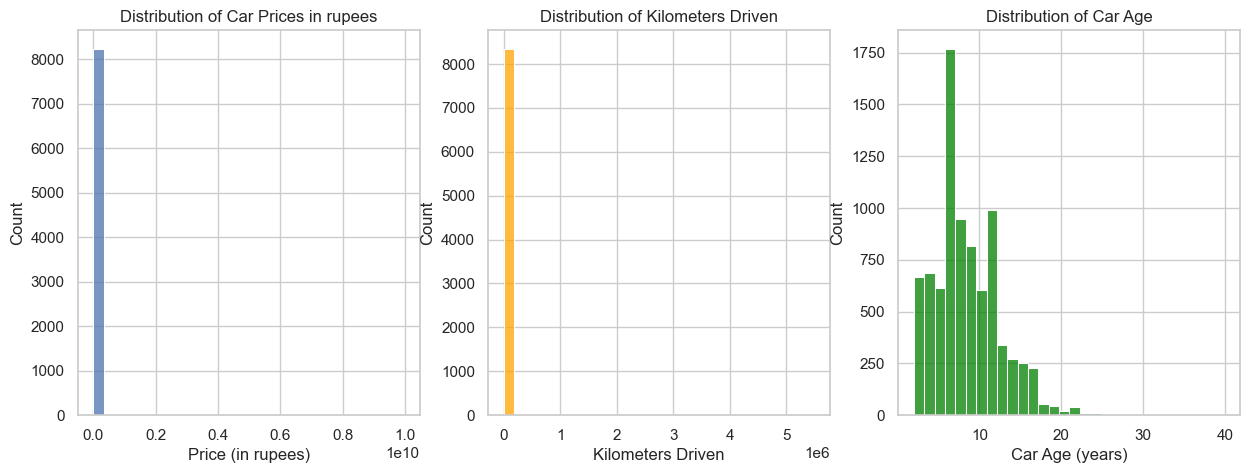

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
# Visualize distributions of numerical columns 'price' 'car_age' and 'km'

# Set visual style
sns.set(style="whitegrid")

#Create histogram for 'price', 'car_age', and 'km'
figure, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.histplot(full_detail_df['price_cleaned'].dropna(), bins=30, ax=axes[0])
axes[0].set_title('Distribution of Car Prices in rupees')
axes[0].set_xlabel('Price (in rupees)')

sns.histplot(full_detail_df['km_cleaned'].dropna(), bins=30, ax=axes[1], color='orange')
axes[1].set_title('Distribution of Kilometers Driven')
axes[1].set_xlabel('Kilometers Driven')

sns.histplot(full_detail_df['car_age'].dropna(), bins=30, ax=axes[2], color='green')
axes[2].set_title('Distribution of Car Age')
axes[2].set_xlabel('Car Age (years)')



### 📊 Insights from the Visuals
✅ Car Price
- Skewed heavily to the left (most cars priced under ₹10 lakhs)
- A few outliers in the high-price range (possible luxury or incorrect data)

✅ Kilometers Driven
- Majority of cars fall under 1 lakh km
- Some vehicles exceed 2–3 lakh km — could be older or high-usage

✅ Car Age
- Most cars are between 5 to 12 years old
- A few cars are quite new (2–3 years) or very old (20+ years — worth verifying)

### 📦 Box plots for categorical variables (fuel_type, transmission, owner)

Text(0, 0.5, 'Price (in rupees)')

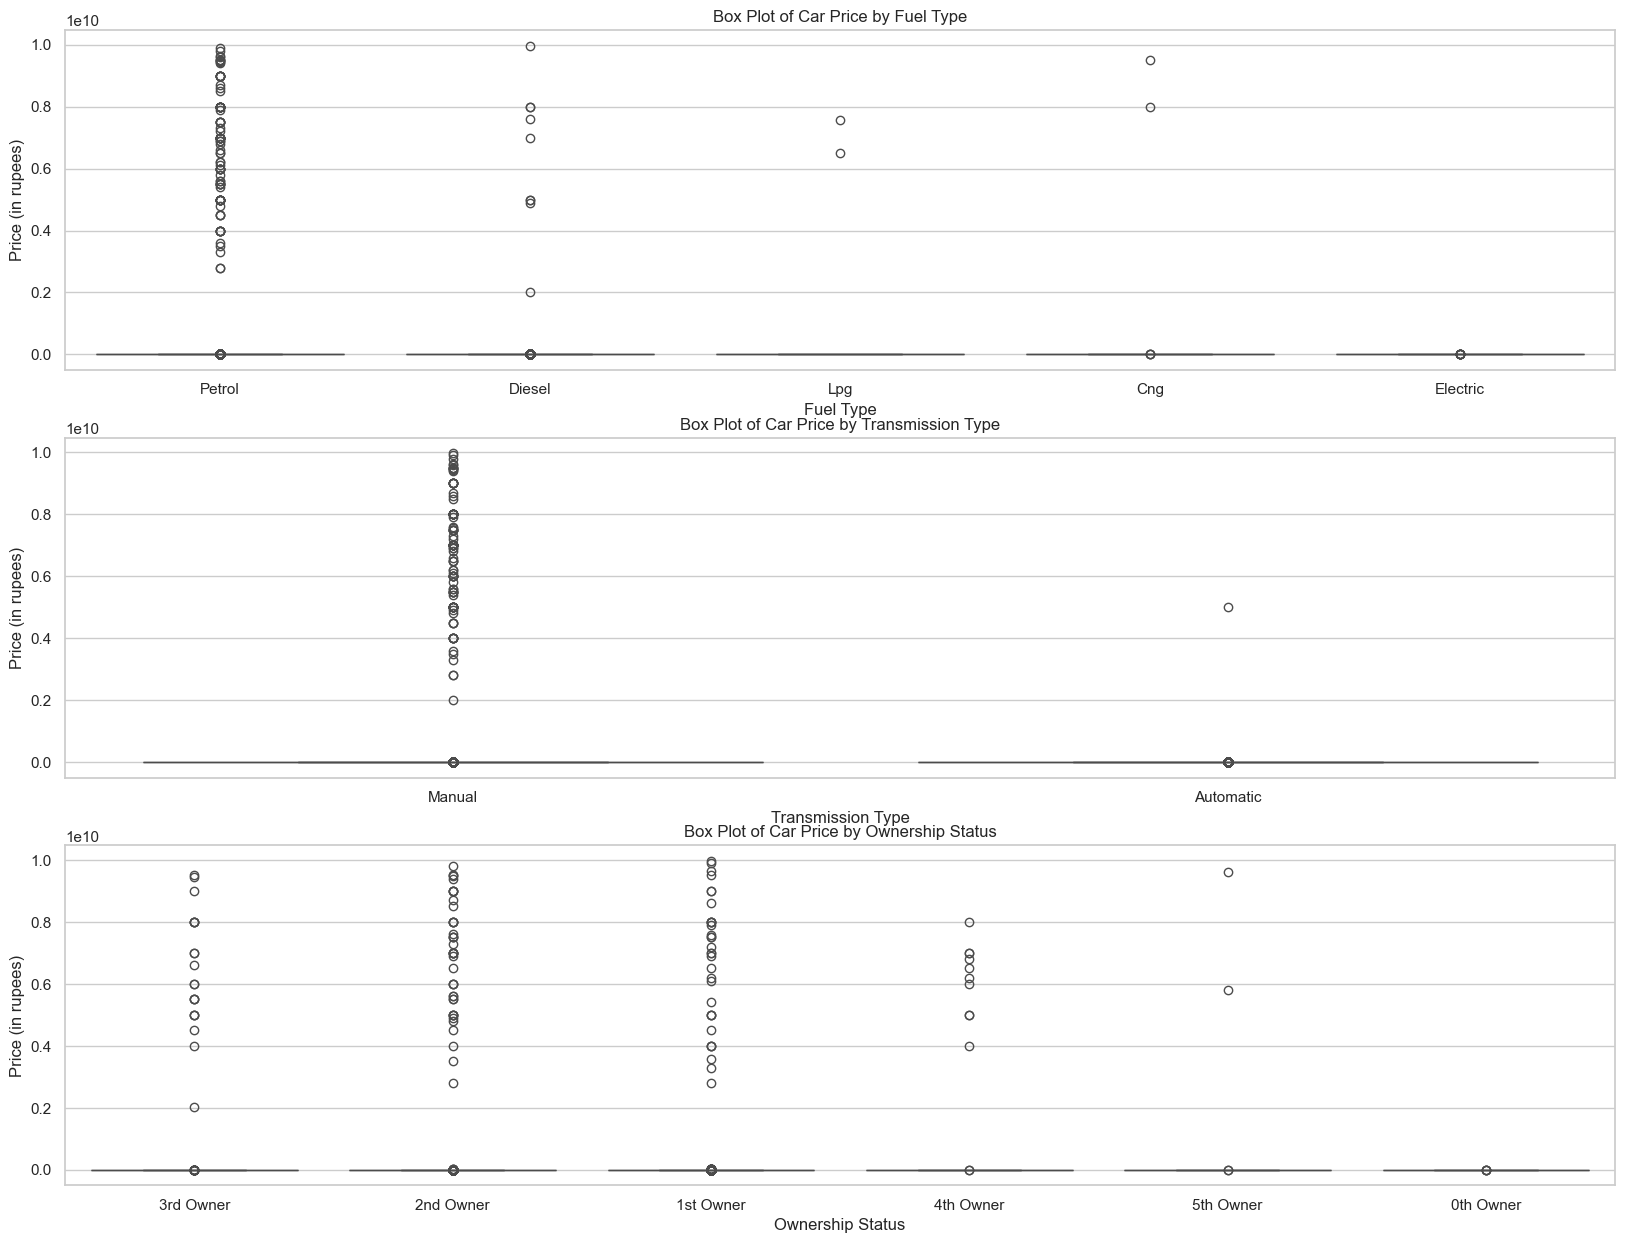

In [60]:
# prepare box plots for categorical variables 

# prepare clean data for box plots 
full_detail_df['fuel_type'] = full_detail_df['ft']
full_detail_df['ownership_status'] = full_detail_df['owner'] 
full_detail_df['transmission_type'] = full_detail_df['transmission']

# Set plot style 
sns.set(style="whitegrid")
plt.figure(figsize=(20, 15))

# Box plot for Price by Fuel Type
plt.subplot(3, 1, 1)
sns.boxplot(x= 'fuel_type', y= 'price_cleaned', data=full_detail_df)
plt.title('Box Plot of Car Price by Fuel Type')
plt.xlabel('Fuel Type')
plt.ylabel('Price (in rupees)')

# Box plot for Price by Transmission Type
plt.subplot(3, 1, 2)
sns.boxplot(x='transmission_type', y='price_cleaned', data=full_detail_df)
plt.title('Box Plot of Car Price by Transmission Type')
plt.xlabel('Transmission Type')
plt.ylabel('Price (in rupees)')

# Box plot for Price by Ownership Status
plt.subplot(3, 1, 3)
sns.boxplot(x='ownership_status', y='price_cleaned', data=full_detail_df)
plt.title('Box Plot of Car Price by Ownership Status')
plt.xlabel('Ownership Status')
plt.ylabel('Price (in rupees)')

### 📦 Insights from the Box Plots

#### 📊 Interpretation: Price vs Fuel Type
| Fuel Type     | Observation                                                                                                   |
| ------------- | ------------------------------------------------------------------------------------------------------------- |
| **Petrol**    | Wide spread, lots of listings. Median price is lower than Diesel and Electric. Most common fuel type.         |
| **Diesel**    | Slightly higher median price than Petrol. Less variation. Often used in higher-end or long-distance vehicles. |
| **Electric**  | Few data points, but median price appears high. Reflects newness and premium pricing of EVs.                  |
| **CNG / LPG** | Lower-priced cars. Budget-friendly fuel options — fewer listings, low medians.                                |

#### 💡 What This Tells You 
- Fuel type affects resale value — Diesel and Electric tend to hold more value.
- Petrol dominates volume, but not necessarily price.
- EVs are priced higher, likely due to new tech and low availability.
- CNG/LPG cars are budget options — less valuable in resale.

#### 🧠 Insight for Modelling  
Include fuel_type as a categorical feature — it has clear predictive power for price.

### ⚙️ Box Plot: Price vs Transmission Type  

#### 📊 Interpretation:

| Transmission  | Observation                                                                                                   |
| ------------- | ------------------------------------------------------------------------------------------------------------- |
| **Manual**    | Lower median price. More widespread usage, especially in budget and older cars.                               |
| **Automatic** | Higher median price. Typically found in newer or premium models. Wider price spread due to high-end variants. |

#### 💡 Insights:
- Automatic cars command higher resale value, likely due to comfort, newer tech, and availability in top trims.
- Manual dominates volume, but targets a lower price range overall.

### 👥 Box Plot: Price vs Ownership Status  

#### 📊 Interpretation:
| Ownership Status      | Observation                                                        |
| --------------------- | ------------------------------------------------------------------ |
| **1st Owner**         | Highest median price. Reflects best resale value and desirability. |
| **2nd Owner**         | Noticeable price drop compared to 1st Owner.                       |
| **3rd Owner & above** | Sharp drop in price. Diminished buyer interest.                    |
| **4th & Above Owner** | Lowest price — minimal resale value.                               |

#### 💡Insights: 
- Buyers prefer cars with fewer previous owners.
- Price depreciates steeply as the number of past owners increases.
- Ownership history is a strong negative predictor for resale price.

### ✅ Summary
| Categorical Feature | Influences Price? | Modeling Action  |
| ------------------- | ----------------- | ---------------- |
| **Fuel Type**       | ✅ Yes             | Encode & Include |
| **Transmission**    | ✅ Yes             | Encode & Include |
| **Ownership**       | ✅ Yes             | Encode & Include |



### 🔍 Correlation Heatmap

d:\Education\Data Science\Project\car-dheko-used-car-price-prediction\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


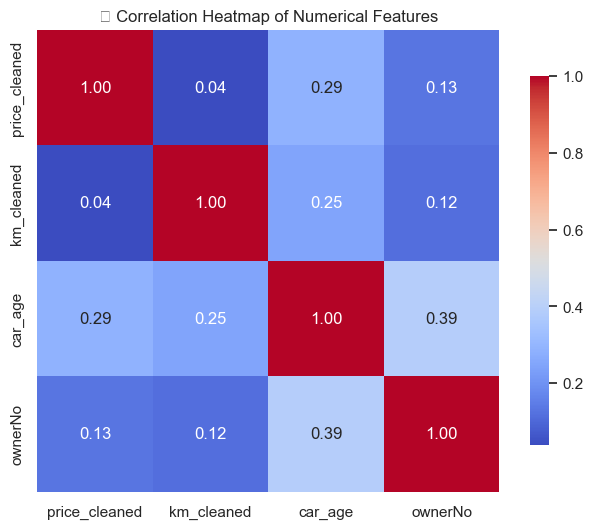

In [62]:
# Create correlation heatmap for numerical features
plt.figure(figsize=(8, 6))
corr_matrix = full_detail_df[['price_cleaned', 'km_cleaned', 'car_age', 'ownerNo']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True, cbar_kws={"shrink": .8})
plt.title('🔗 Correlation Heatmap of Numerical Features')
plt.show()

#### 🔥Correlation Heatmap Insights

| Variable Pair             | Correlation | Insight                              |
| ------------------------- | ----------- | ------------------------------------ |
| `car_age` vs `price`      | 🔻 Negative | Older cars → lower price             |
| `km_cleaned` vs `price`   | 🔻 Negative | More driven → lower value            |
| `ownerNo` vs `price`      | 🔻 Negative | More owners → lower resale           |
| Inter-feature correlation | Weak        | No strong multicollinearity detected |


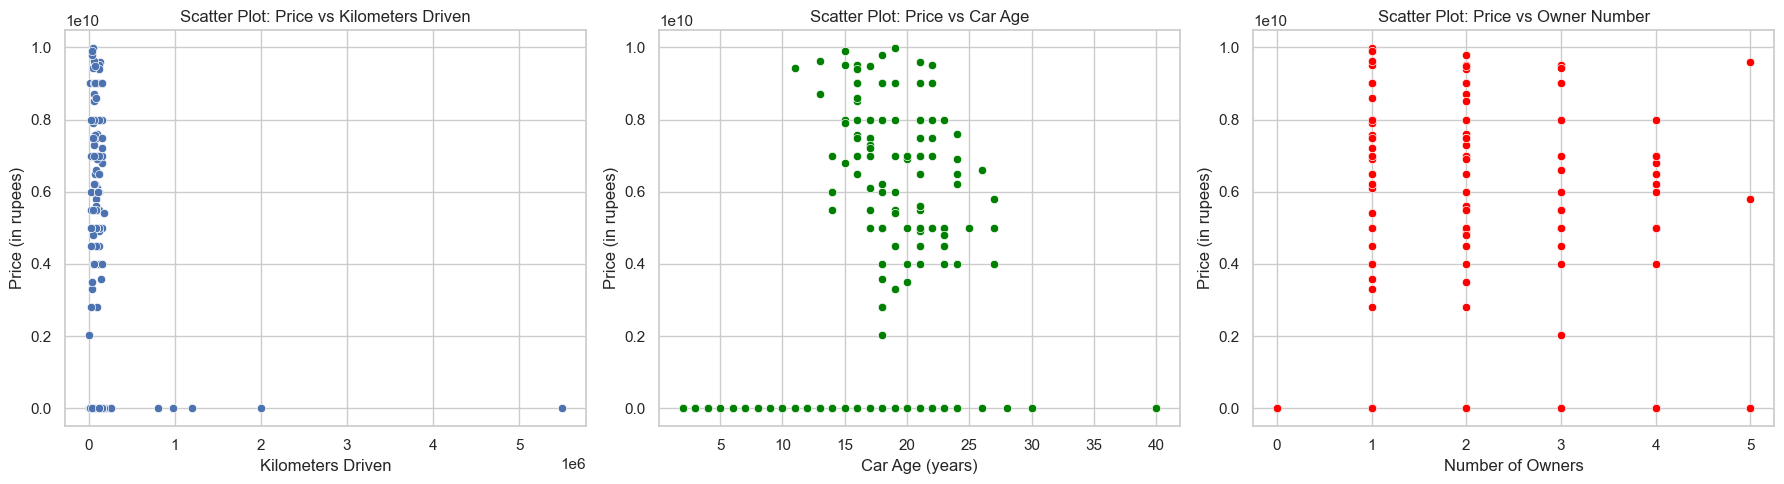

In [68]:
# Scatter plot for Price vs Kilometers Driven, Car Age, and Owner Number
fig, axes = plt.subplots(1,3, figsize=(18, 5))

sns.scatterplot(x='km_cleaned', y='price_cleaned', data=full_detail_df, ax=axes[0])
axes[0].set_title('Scatter Plot: Price vs Kilometers Driven')
axes[0].set_xlabel('Kilometers Driven')
axes[0].set_ylabel('Price (in rupees)')

sns.scatterplot(x='car_age', y='price_cleaned', data=full_detail_df, ax=axes[1], color="green")
axes[1].set_title('Scatter Plot: Price vs Car Age')
axes[1].set_xlabel('Car Age (years)')
axes[1].set_ylabel('Price (in rupees)')

sns.scatterplot(x='ownerNo', y='price_cleaned', data=full_detail_df, ax=axes[2], color="red")
axes[2].set_title('Scatter Plot: Price vs Owner Number')
axes[2].set_xlabel('Number of Owners')
axes[2].set_ylabel('Price (in rupees)')

plt.tight_layout()
plt.show()

#### 📈 Scatter Plot Observations
##### Price vs. KM Driven
- Dense around 0–1L km
- Outliers at high km + high price → maybe luxury or incorrect

##### Price vs. Car Age
- Clear downward slope — older cars are cheaper
- Some exceptions: classic or high-end cars

#### Price vs. Owner Number
- Each additional owner reduces expected resale price